In [31]:
import pandas as pd
import librosa
import numpy as np
import np_utils

from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

from keras.utils import np_utils

train=pd.read_csv('AllBirdsv4.csv')
train.rename(columns={'File ID': 'File_ID'}, inplace=True)

train.head()

,File_ID,English_name,Vocalization_type,Quality,Time,Date,X,Y
0,402254,Rose-crested Blue Pipit,call,no score,13:30,2/8/2018,49,63
1,406171,Rose-crested Blue Pipit,call,A,7:48,6/7/2017,125,133
2,405901,Rose-crested Blue Pipit,call,A,12:00,2/8/2018,58,76
3,405548,Rose-crested Blue Pipit,song,A,11:00,3/10/2018,55,125
4,401782,Rose-crested Blue Pipit,song,A,6:00,6/29/2008,129,123


In [32]:
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [33]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

In [34]:
def file_path ():
    sound_file_paths = []
    sound_names = []
    for i in range (0, 500, 3):
        File_ID = str(train[i:i+1].File_ID.item())
        English_name = str(train[i:i+1].English_name.item()).replace(" ", "-")
        filename = 'ALL BIRDS/'+English_name+'-'+File_ID+'.mp3'
        sound_file_paths.append(filename) 
        sound_names.append (English_name)
        print(filename)
    return sound_file_paths, sound_names

sound_file_paths, sound_names = file_path()

raw_sounds = load_sound_files(sound_file_paths)

ALL BIRDS/Rose-crested-Blue-Pipit-402254.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-405548.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-401719.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-368493.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-353709.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-298739.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-277989.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-225347.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-164501.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-162569.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-162564.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-139528.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-120731.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-118320.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-106772.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-70544.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-35964.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-12122.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-383970.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-362922.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-345802.mp3
ALL BIRDS/Rose-crested-Blue-Pipit-345796.mp3
ALL BIRDS/Ros

In [35]:
#print(sound_file_paths)
#print(sound_names)
#print(raw_sounds)

In [36]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(sound_file_paths,sound_names):
    features, labels = np.empty((0,193)), np.empty(0)
    for i in range (len(sound_file_paths)):
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(sound_file_paths[i])
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        #labels = np.append(sound_names[i])
        i +=1
    return np.array(features), np.array(sound_names, dtype = np.str)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [37]:
features, labels = parse_audio_files(sound_file_paths, sound_names)

C:\Users\piega\Anaconda3\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [38]:
nameList = np.unique(labels)
print(labels)
print(nameList)

['Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-Pipit'
 'Rose-crested-Blue-Pipit' 'Rose-crested-Blue-

In [39]:
labels_int = []
for i in range (len(nameList)):
        labels_int += [[i, nameList[i]]]
print(labels_int)

for i in range(len(labels)):
    for j in range (len(labels_int)):
        if (labels[i]==labels_int[j][1]):
            labels[i]=labels_int[j][0]


[[0, 'Blue-collared-Zipper'], [1, 'Bombadil'], [2, 'Broad-winged-Jojo'], [3, 'Canadian-Cootamum'], [4, 'Rose-crested-Blue-Pipit']]


In [40]:
lb = preprocessing.LabelEncoder()
labels=np_utils.to_categorical(lb.fit_transform(labels))

In [41]:
#labels = one_hot_encode(labels)

train_test_split = np.random.rand(len(features)) < 0.90
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]

In [42]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

In [43]:
training_epochs = 5000
n_dim = features.shape[1]
n_classes = len(nameList)
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [44]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [45]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [46]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))


C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


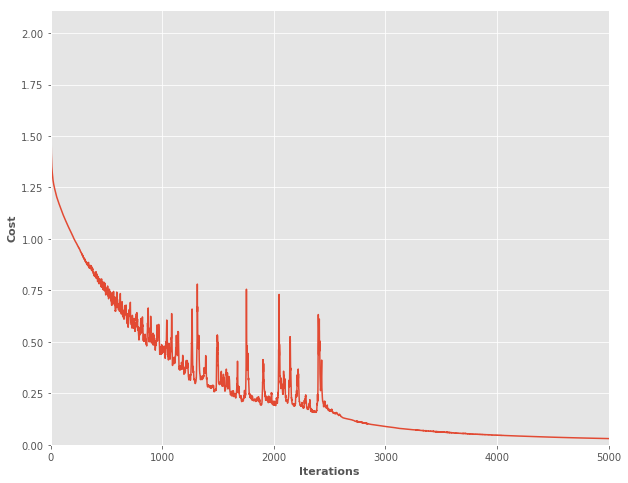

F-Score: 0.667


In [47]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print ("F-Score:", round(f,3))